# Adversarial Examples

**Arun Das**    
***Understanding the Nuts and Bolts of Adversarial Example Pipeline***

The aim of this Jupyter Notebook is to share a small but complete codebase to generate and save adversarial examples. 

**Comment from Author**: I use here [Foolbox](https://github.com/bethgelab/foolbox) to generate adversarial examples to misclassify a cat as a zebra. One of the main issues with generating adversarial examples is that the array object generated needs to be saved in a proper format. JPEG compresses the adversariale examples and loses the injected pertubations. Hence, I save the adversarial images as TIFF. TIFF saves the images without any compression and is thus generally lossless (unless you intentionally reduce the quality by resampling). I share here my short experience with FoolBox. Also, a disclaimer that there might be better ways to use FoolBox and get the most out of it. I am just starting to understand FoolBox.

To recreate this example, please make sure `foolbox, keras, Pillow, scikit-image, matplotlib` are installed.

#### In a gist, we fool a ResNet classifier to classify a Cat as a Zebra; Enjoy :)

### Import required packages

In [1]:
#=============== GPU Fractions for multiple DNNs

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

#=============== FOR FOOLBOX MODEL

import foolbox
from foolbox.models import KerasModel
from foolbox.attacks import LBFGSAttack
from foolbox.criteria import TargetClassProbability
import numpy as np
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
# from skimage.measure import structural_similarity as ssim
from skimage.measure import compare_ssim as ssim
keras.backend.set_learning_phase(0)
from pprint import pprint
from keras.preprocessing import image

#=============== HELPER FUNCTIONS FOR FOOLBOX MODEL

def mse(imageA, imageB):
    """
    Code obtained from: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
    """
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

def compare_images(imageA, imageB, title="Comparision"):
    """
    Code obtained from: https://www.pyimagesearch.com/2014/09/15/python-compare-two-images/
    """
    # compute the mean squared error and structural similarity
    # index for the images
    m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel=True)

    # setup the figure
    fig = plt.figure(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA)#, cmap = plt.cm.gray)
    plt.axis("off")

    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB)#, cmap = plt.cm.gray)
    plt.axis("off")

    # show the images
    plt.show()


def showimage(image):
    """
    Helper function to show image in Jupyter
    
    Requires:
    from PIL import Image
    from matplotlib.pyplot import imshow
    
    Example:
    showimage('/home/user/file.jpg')
    --
    img = Image.open('/home/user/file.jpg')
    showimage(img)
    """
    if type(image)==str:
        img = Image.open(image)
    elif type(image)==np.ndarray:
        img = Image.fromarray(image, 'RGB')
    elif type(image)==Image:
        image.show
        pass
    else:
        raise ValueError("Image is not in a known format.")
    imshow(img)
    
def loadimage(image, dtype='uint8'):
    """
    Helper function to load image as array in Jupyter
    
    Requires:
    from PIL import Image
    import numpy as np
    
    Example:
    img = loadimage('/home/user/file.jpg')
    -- load from array
    img = Image.open('/home/user/file.jpg')
    img = loadimage(img)
    """
    if type(image)==str:
        img = Image.open(image)
    elif type(image)==np.ndarray:
        img = Image.fromarray(image, 'RGB')
    else:
        raise ValueError("Image is not in a known format.")
    return np.asarray(img, dtype=dtype)

%matplotlib inline

/home/arundas/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load DL Model and wrap with FoolBox

In [2]:
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
fmodel = KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

*fmodel* is the FoolBox Model based on Keras

### Load the image and read as *np.float32*. 

oci_vision_adversarial/foolbox/foolbox/utils.py

In [3]:
orig_image, label = foolbox.utils.imagenet_example()

#### Actual float32 image
The image is not interpretable by humans.

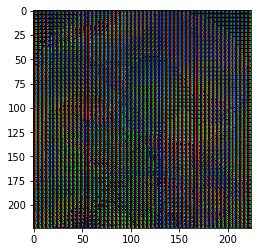

In [4]:
showimage(orig_image)

**Comment from Author**: As you'll see later in the notebook, there are two key points to note: 1) FoolBox imagenet/classification based attacks requires images of dtype `float32` in RGB color channel to work properly. 2) Attacked images are in BGR format and changing them to RGB partially removes the pertubations.

#### Show the image as uint8
The image is now clearly interpretable as a cat.

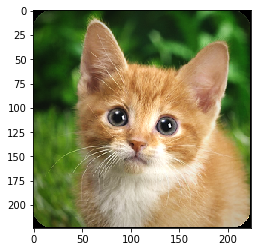

In [5]:
showimage(orig_image.astype('uint8'))

### Attack the image. Try a targeted attack.

In [6]:
# run the attack
target_class = 340 #zebra
target_threshold = 0.5
attack = LBFGSAttack(model=fmodel, criterion=TargetClassProbability(target_class, p=target_threshold))
adversarial = attack(orig_image[:, :, ::-1], label, unpack=False)

# show results
print("Adversarial prediction: {}".format(np.argmax(fmodel.predictions(adversarial.image))))
print("Adversarial probability: {}".format(foolbox.utils.softmax(fmodel.predictions(adversarial.image))[target_class]))

Adversarial prediction: 340
Adversarial probability: 0.7974433302879333


### Show the Adversarial Image as is.
The image is still not human interpretable.

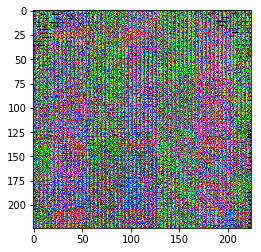

In [7]:
showimage(adversarial.image)

#### Data-type of Adversarial Image

In [8]:
print("Data-type of Adversarial Image: {}".format(adversarial.image.dtype))

Data-type of Adversarial Image: float32


### Show the Adversarial Image as 'uint8'.
The image is human interpretable. However, there are doubts whether this image will give proper misclassifications.

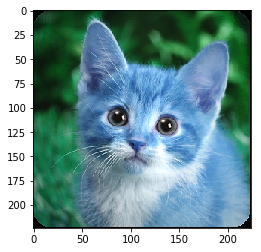

In [9]:
showimage(adversarial.image.astype('uint8'))

We see that the channel is in BGR format and not RGB. This is an important note.

Convert BGR to RGB

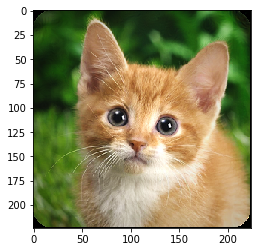

In [10]:
showimage(adversarial.image[:, :, ::-1].astype('uint8'))

#### Statistically compare the original and aversarial images.

#### Comparing images as is.

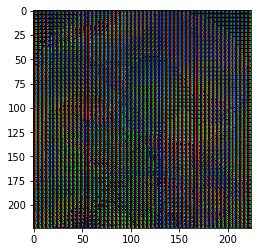

In [11]:
showimage(orig_image)

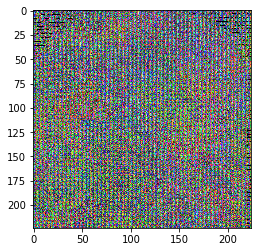

In [12]:
showimage(adversarial.image[:, :, ::-1])

This is the adversarial image in RGB channels. Now let's compare the two images.

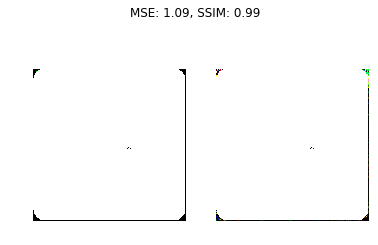

In [13]:
compare_images(orig_image, adversarial.image[:, :, ::-1])

The Mean Squared Error and Structural Similarity are compared and noted here.

### Compare the RGB 'uint8' version

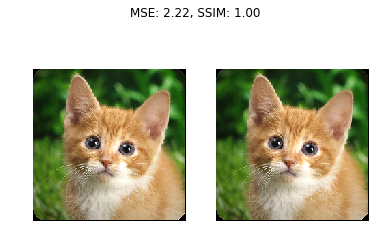

In [14]:
compare_images(orig_image.astype('uint8'), adversarial.image[:, :, ::-1].astype('uint8'))

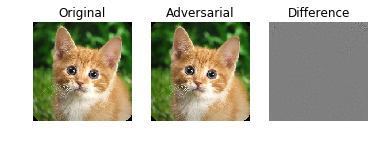

In [15]:
plt.figure()

plt.subplot(1, 3, 1)
plt.title('Original')
plt.imshow(orig_image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Adversarial')
plt.imshow(adversarial.image[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial.image[:, :, ::-1] - orig_image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

### Get the predictions for adversarial image (float32 - FoolBox generated).

In [16]:
# add a 'batch' axis for prediction by an external model.
adversarial_rgb = adversarial.image[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(adversarial_rgb.copy()))
print("Top 5 predictions (adversarial example):")
pprint(decode_predictions(preds, top=5))

Top 5 predictions (adversarial example):
[[('n02391049', 'zebra', 0.78543013),
  ('n02123159', 'tiger_cat', 0.05411426),
  ('n02123045', 'tabby', 0.035837714),
  ('n02127052', 'lynx', 0.021661924),
  ('n02124075', 'Egyptian_cat', 0.008780676)]]


### Save and Load the Adversarial Example.

It is important to confirm the working of the advesarial example even when the image is saved. This could later help in data poisoning attacks.

#### Save image as TIFF image file.

In [17]:
adversarial_as_img = image.array_to_img(adversarial.image)

In [18]:
adversarial_as_img.save('adversarial_cat.tiff', format='tiff')

#### Load image and Predict.

In [19]:
loaded_advim = image.load_img('adversarial_cat.tiff', target_size=(224,224))
img = image.img_to_array(loaded_advim)
img_rgb = np.asarray(img)[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(img_rgb.copy()))
print("Top 5 predictions (adversarial example):")
pprint(decode_predictions(preds, top=5))

Top 5 predictions (adversarial example):
[[('n02391049', 'zebra', 0.79395443),
  ('n02123159', 'tiger_cat', 0.0475153),
  ('n02123045', 'tabby', 0.032057572),
  ('n02127052', 'lynx', 0.020658383),
  ('n02119789', 'kit_fox', 0.008966941)]]


#### Convert adversarial example from BGR to RGB.

In [20]:
loaded_advim = image.load_img('adversarial_cat.tiff', target_size=(224,224))
img = image.img_to_array(loaded_advim)
img = img[:, :, ::-1]
img_rgb = np.asarray(img)[np.newaxis, :, :, ::-1]
preds = kmodel.predict(preprocess_input(img_rgb.copy()))
print("Top 5 predictions (adversarial example):")
pprint(decode_predictions(preds, top=5))

Top 5 predictions (adversarial example):
[[('n02127052', 'lynx', 0.4215471),
  ('n02119789', 'kit_fox', 0.1047522),
  ('n02123597', 'Siamese_cat', 0.07712667),
  ('n02124075', 'Egyptian_cat', 0.052916203),
  ('n02123045', 'tabby', 0.052042726)]]


**Comment from Author**: We see that the targetted attack does not work anymore. This is a disadvantage since humans can clearly identify the differences in color channel just by looking at the image (because of the changes in hue). A more stringent adversary needs to be explored.